##Configurações

In [1]:
!pip install scikeras==0.12.0
!pip install keras==2.15.0
!pip install tensorflow

  Using cached keras-2.15.0-py3-none-any.whl.metadata (2.4 kB)
Using cached keras-2.15.0-py3-none-any.whl (1.7 MB)
  Attempting uninstall: keras
    Found existing installation: keras 3.5.0
    Uninstalling keras-3.5.0:
      Successfully uninstalled keras-3.5.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow 2.17.0 requires keras>=3.2.0, but you have keras 2.15.0 which is incompatible.
  Using cached keras-3.5.0-py3-none-any.whl.metadata (5.8 kB)
Using cached keras-3.5.0-py3-none-any.whl (1.1 MB)
  Attempting uninstall: keras
    Found existing installation: keras 2.15.0
    Uninstalling keras-2.15.0:
      Successfully uninstalled keras-2.15.0


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
import matplotlib.pyplot as plt

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [4]:
#Metodos Para Calcular o Theils U Coefficient
def division(measure, previousI):
  return measure / previousI

def power(measure):
  return np.power(measure, 2)

def summation(measure):
  return np.sum(measure)

def mean(N, measure):
  return (1/N) * measure

def sqrt(measure):
  return np.sqrt(measure)

def theil_u2(y_true, y_pred):
    y_true = np.ravel(y_true)
    y_pred = np.ravel(y_pred)
    N = len(y_true)

    subtractionNumerator = y_pred[1:] - y_true[1:]
    divisionNumerator = division(subtractionNumerator, y_true[:-1])
    powerNumerator = power(divisionNumerator)
    summationNumerator = summation(powerNumerator)
    meanNumerator = mean(N, summationNumerator)
    numerator = sqrt(meanNumerator)

    subtractionDenominator = y_true[1:] - y_true[:-1]
    powerDenominator = power(division(subtractionDenominator, y_true[:-1]))
    denominator = sqrt(mean(N, summation(powerDenominator)))

    theilU2 = numerator / denominator

    return theilU2

## Grafico

In [5]:
dataset = pd.read_csv('/content/drive/My Drive/Projeto Internações/Preparação dos dados/dataset_internacoes_completo.csv')

In [6]:
dataset

,Qtd. internacoes,Data completa,UF,Município,populacao
0,14,2010-01-01,AC,ACRELÂNDIA,13081.0
1,7,2010-01-01,AC,ASSIS BRASIL,6335.0
2,48,2010-01-01,AC,BRASILÉIA,22325.0
3,2,2010-01-01,AC,BUJARI,8838.0
4,4,2010-01-01,AC,CAPIXABA,9179.0
...,...,...,...,...,...
1024875,28,2024-04-01,TO,TOCANTINÓPOLIS,23102.0
1024876,1,2024-04-01,TO,TUPIRAMA,1608.0
1024877,1,2024-04-01,TO,TUPIRATINS,2142.0
1024878,12,2024-04-01,TO,WANDERLÂNDIA,11216.0


In [7]:
dataset['populacao'].dtype

dtype('float64')

In [8]:
def porte(populacao):
  if populacao <= 20000:
    return 'Pequeno Porte I'
  elif populacao >= 20001 and populacao <= 50000 :
    return 'Pequeno Porte II'
  elif populacao >= 50001 and populacao <= 100000:
    return 'Médio Porte'
  elif populacao >= 100001 and populacao <= 900000:
    return 'Grande Porte'
  elif populacao >= 900001:
    return 'Metrópole'

In [9]:
def taxa_internacao (row):
  return row['Qtd. internacoes']*1000/row['populacao']

In [24]:
dataset['taxa_internacao'] = dataset.apply(taxa_internacao, axis =1)

<ipython-input-24-5efc2a6ac78c>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset['taxa_internacao'] = dataset.apply(taxa_internacao, axis =1)


In [11]:
dataset['Porte'] = dataset['populacao'].apply(porte)

In [12]:
dataset

,Qtd. internacoes,Data completa,UF,Município,populacao,taxa_internacao,Porte
0,14,2010-01-01,AC,ACRELÂNDIA,13081.0,1.070255,Pequeno Porte I
1,7,2010-01-01,AC,ASSIS BRASIL,6335.0,1.104972,Pequeno Porte I
2,48,2010-01-01,AC,BRASILÉIA,22325.0,2.150056,Pequeno Porte II
3,2,2010-01-01,AC,BUJARI,8838.0,0.226296,Pequeno Porte I
4,4,2010-01-01,AC,CAPIXABA,9179.0,0.435777,Pequeno Porte I
...,...,...,...,...,...,...,...
1024875,28,2024-04-01,TO,TOCANTINÓPOLIS,23102.0,1.212016,Pequeno Porte II
1024876,1,2024-04-01,TO,TUPIRAMA,1608.0,0.621891,Pequeno Porte I
1024877,1,2024-04-01,TO,TUPIRATINS,2142.0,0.466853,Pequeno Porte I
1024878,12,2024-04-01,TO,WANDERLÂNDIA,11216.0,1.069900,Pequeno Porte I


Filtro

In [13]:
dataset = dataset[dataset['Porte'] == 'Grande Porte']

In [14]:
dataset

,Qtd. internacoes,Data completa,UF,Município,populacao,taxa_internacao,Porte
15,275,2010-01-01,AC,RIO BRANCO,350589.0,0.784394,Grande Porte
24,395,2010-01-01,AL,ARAPIRACA,219165.0,1.802295,Grande Porte
169,86,2010-01-01,AM,PARINTINS,104059.0,0.826454,Grande Porte
192,239,2010-01-01,AP,MACAPÁ,412916.0,0.578810,Grande Porte
198,80,2010-01-01,AP,SANTANA,105003.0,0.761883,Grande Porte
...,...,...,...,...,...,...,...
1024727,52,2024-04-01,SP,VALINHOS,109476.0,0.474990,Grande Porte
1024732,42,2024-04-01,SP,VÁRZEA PAULISTA,109780.0,0.382583,Grande Porte
1024738,81,2024-04-01,SP,VOTORANTIM,111543.0,0.726177,Grande Porte
1024752,234,2024-04-01,TO,ARAGUAÍNA,153698.0,1.522466,Grande Porte


In [15]:
time_series = dataset[['Data completa', 'taxa_internacao']]
time_series['Data completa'] = pd.to_datetime(time_series['Data completa'])

<ipython-input-15-8980fe5bf9f1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  time_series['Data completa'] = pd.to_datetime(time_series['Data completa'])


In [16]:
time_series = time_series.set_index('Data completa').resample('M').mean()

In [17]:
time_series

,taxa_internacao
Data completa,
2010-01-31,0.848591
2010-02-28,0.819916
2010-03-31,0.868586
2010-04-30,0.855718
2010-05-31,0.868364
...,...
2023-12-31,0.775945
2024-01-31,0.792018
2024-02-29,0.761027


In [18]:
time_series = time_series['2010-1-1':'2024-04-30']

In [19]:
previsao_2010 = pd.read_csv('/content/drive/My Drive/Projeto Internações/Resultados LSTM/predicao_previne_brasil_grande_porte_sem_dados_inputados(2010).csv')
previsao_2012 = pd.read_csv('/content/drive/My Drive/Projeto Internações/Resultados LSTM/predicao_previne_brasil_grande_porte_sem_dados_inputados(2012).csv')
previsao_2014 = pd.read_csv('/content/drive/My Drive/Projeto Internações/Resultados LSTM/predicao_previne_brasil_grande_porte_sem_dados_inputados(2014).csv')
previsao_2016 = pd.read_csv('/content/drive/My Drive/Projeto Internações/Resultados LSTM/predicao_previne_brasil_grande_porte_sem_dados_inputados(2016).csv')

In [20]:
previsao_2010

,previsao,valor_real
0,0.609230,0.708828
1,0.655669,0.644842
2,0.660827,0.736128
3,0.673911,0.754235
4,0.701104,0.795934
5,0.733264,0.768096
6,0.732651,0.794809
7,0.725674,0.809357
8,0.732399,0.797900
9,0.738768,0.793068


In [21]:
dates = pd.date_range(start='2022-01-01', periods=len(previsao_2010), freq='M')

# Adicione essas datas como índice ao DataFrame
previsao_2010.index = dates

# Verifique o DataFrame
print(previsao_2010)

            previsao  valor_real
2022-01-31  0.609230    0.708828
2022-02-28  0.655669    0.644842
2022-03-31  0.660827    0.736128
2022-04-30  0.673911    0.754235
2022-05-31  0.701104    0.795934
2022-06-30  0.733264    0.768096
2022-07-31  0.732651    0.794809
2022-08-31  0.725674    0.809357
2022-09-30  0.732399    0.797900
2022-10-31  0.738768    0.793068
2022-11-30  0.738763    0.752332
2022-12-31  0.719512    0.757042
2023-01-31  0.709528    0.754890
2023-02-28  0.715940    0.756369
2023-03-31  0.731201    0.820010
2023-04-30  0.768281    0.828922
2023-05-31  0.796806    0.866061
2023-06-30  0.813409    0.849036
2023-07-31  0.805817    0.858686
2023-08-31  0.793525    0.867701
2023-09-30  0.792929    0.800018
2023-10-31  0.766986    0.811705
2023-11-30  0.752024    0.791590
2023-12-31  0.750916    0.775945
2024-01-31  0.752099    0.792018
2024-02-29  0.764631    0.761027
2024-03-31  0.762114    0.809141
2024-04-30  0.775421    0.813512


In [22]:
previsao_2012.index = dates
previsao_2014.index = dates
previsao_2016.index = dates

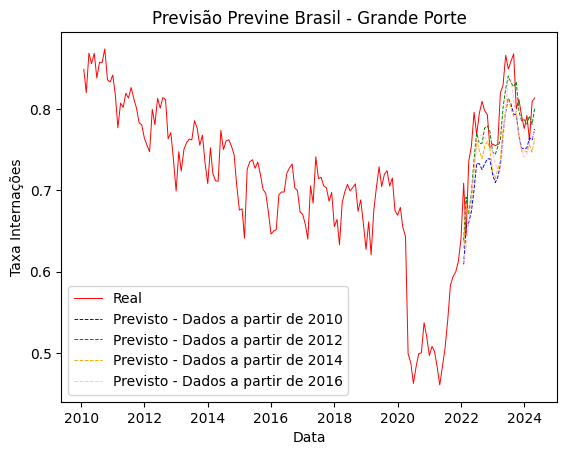

In [23]:
plt.plot(time_series, color='red', linewidth=0.7, label = 'Real')
plt.plot(previsao_2010['previsao'], color='blue', linestyle='--', linewidth=0.7, label = 'Previsto - Dados a partir de 2010')
plt.plot(previsao_2012['previsao'], color='green', linestyle='--', linewidth=0.7, label = 'Previsto - Dados a partir de 2012')
plt.plot(previsao_2014['previsao'], color='orange', linestyle='--', linewidth=0.7, label = 'Previsto - Dados a partir de 2014')
plt.plot(previsao_2016['previsao'], color='pink', linestyle='--', linewidth=0.7, label = 'Previsto - Dados a partir de 2016')
plt.title('Previsão Previne Brasil - Grande Porte')
plt.ylabel('Taxa Internações')
plt.xlabel('Data')
plt.legend()
plt.show()